### Whole-brain model 

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/Documentos/phase_amplitude_encoding/")

In [2]:
import jax
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from frites.core import copnorm_nd
from hoi.core import get_mi
from mne.time_frequency.tfr import tfr_array_morlet
from mne.time_frequency import psd_array_multitaper
from tqdm import tqdm

from src.models import simulate, simulate_delayed

/home/vinicius/anaconda3/envs/test_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
jax.config.update("jax_platform_name", "cpu")

In [4]:
# Extract area names
def _extract_roi(roi, sep):
    # Code by Etiene
    x_s, x_t = [], []
    for r in roi:
        _x_s, _x_t = r.split(sep)
        x_s.append(_x_s), x_t.append(_x_t)
    roi_c = np.c_[x_s, x_t]
    idx = np.argsort(np.char.lower(roi_c.astype(str)), axis=1)
    roi_s, roi_t = np.c_[[r[i] for r, i in zip(roi_c, idx)]].T
    return roi_s, roi_t

In [5]:
area_names = [
    "V1",
    "V2",
    "V4t",
    "DP",
    "MT",
    "a8M",
    "a5",
    "a8L",
    "TEO",  ##
    "a2",
    "F1",
    "STPc",
    "a7A",
    "a46D",
    "10",  ##
    "a46V",  ## orginally a9/46V
    "a9/46D",
    "F5",  ##
    "TEpd",  ##
    "PBr",  ##
    "7m",  ##
    "a7B",
    "F2",
    "STPi",  ##
    "PROm",  ##
    "F7",
    "a8B",
    "STPr",  ##
    "a24c",
]

In [6]:
peak_freqs = xr.load_dataarray("data/peak_freqs.nc")
_, roi_data = _extract_roi(peak_freqs.roi.values, "_")
peak_freqs = peak_freqs.assign_coords({"roi": roi_data}).groupby("roi").mean("roi")

In [7]:
np.sort(peak_freqs.roi.values)

array(['AIP', 'Core', 'DP', 'F1', 'F2', 'F6', 'F7', 'LIP', 'MST', 'MT',
       'PIP', 'SII', 'STPc', 'TPt', 'V1', 'V2', 'V4t', 'V6A', 'VIP', 'a1',
       'a2', 'a24c', 'a3', 'a44', 'a46D', 'a46V', 'a5', 'a7A', 'a7B',
       'a8B', 'a8L', 'a8M', 'a8r', 'a9/46D'], dtype=object)

In [8]:
f_model = []

for area in area_names:
    if area in peak_freqs.roi.values:
        f_model += [peak_freqs[0].sel(roi=area)]
    else:
        f_model += [-1]

f_model = xr.DataArray(f_model, dims=("roi"), coords=(area_names,))

f_model.values[8] = f_model.values[7]
f_model.values[14] = f_model.values[13]
f_model.values[17] = f_model.values[16]
f_model.values[18] = f_model.values[17]
f_model.values[19] = f_model.values[18]
f_model.values[20] = f_model.values[19]
f_model.values[23] = f_model.values[22]
f_model.values[24] = f_model.values[23]
f_model.values[27] = f_model.values[26]

Text(0, 0.5, 'node peak frequency [Hz]')

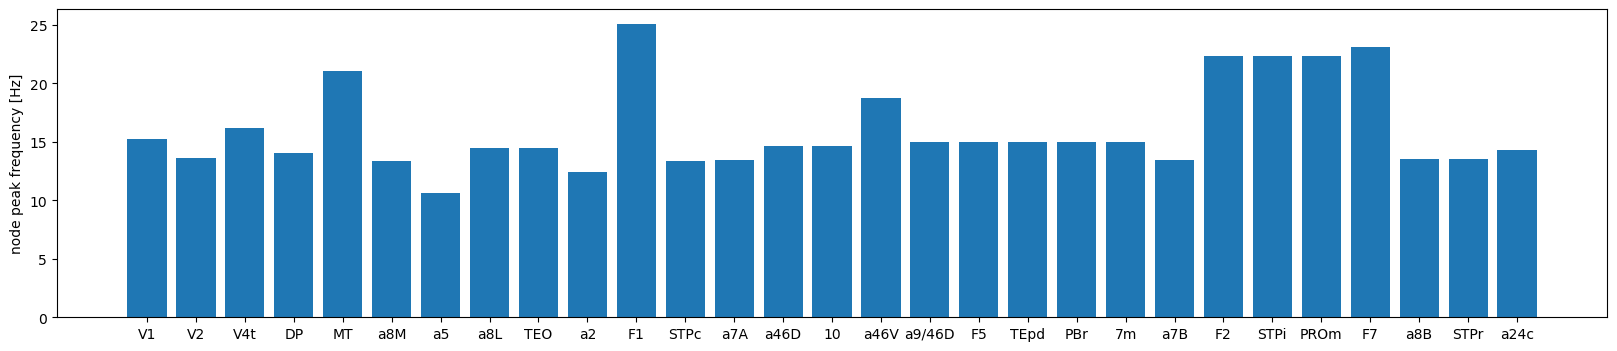

In [9]:
plt.figure(figsize=(20, 4))
plt.bar(f_model.roi, f_model)
plt.ylabel("node peak frequency [Hz]")

#### Load anatomical data

In [10]:
data = np.load("../interareal/markov2014.npy", allow_pickle=True).item()

# Graph parameters
Nareas = 29  # Number of areas
# FLN matrix
flnMat = data["FLN"]
# Distance matrix
D = data["Distances"] * 1e-3 / 3.5
# Hierarchy values
h = np.squeeze(data["Hierarchy"].T)

eta = 4.0

#### Simulation parameters

In [58]:
ntrials = 50
dt = 1e-5
fsamp = 1 / dt
time = np.arange(-3, 3, 1 / fsamp)
beta = 1e-4
Npoints = len(time)
decim = 200
f = 40  # np.linspace(20, 60, Nareas)[::-1]  # Node natural frequency in Hz

flnMat = (1 + eta * h)[:, np.newaxis] * flnMat

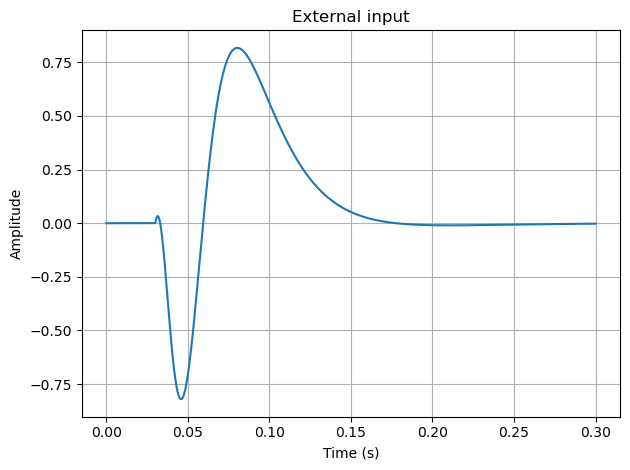

In [59]:
t_input = np.arange(0, 0.3, dt)  # Extend to 500 ms

def alpha_function(t, t_peak=0.1, tau=0.05):  # Increase tau
    """Alpha function envelope with t_peak as an additional parameter."""
    envelope = (t / t_peak) * np.exp(-t / tau)
    envelope[t < 0] = 0  # Ensure no negative time values
    return envelope / np.max(envelope)  # Normalize

envelope = alpha_function(t_input - 0.03, t_peak=5., tau=0.03)  # Increase tau

freq_start = 70  # Hz
freq_end = 1  # Hz
freq_decay = freq_start * np.exp(-30 * t_input) + freq_end  # Slower decay

phase = np.cumsum(2 * np.pi * freq_decay * dt)  # Integrate frequency to get phase
input = np.sin(phase) * envelope  # Modulate with envelope

plt.plot(t_input, input)
plt.title("External input")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)

plt.tight_layout()

In [60]:
Iext = np.zeros((Nareas, Npoints))
Iext[0, (time >= 0) & (time <= 0.3)] = input
Amplitudes = np.linspace(0, .1, ntrials)
CS = Amplitudes[..., None, None] * Iext
seeds = np.random.randint(0, 10000, ntrials)

In [61]:
out = []
for trial in tqdm(range(ntrials)):

    out += [
        simulate(
            flnMat,
            1,
            f_model.values,
            np.linspace(-5, +5, Nareas),
            fsamp,
            beta,
            Npoints,
            CS[trial] * 0,
            seeds[trial],
            decim=decim,
            stim_mode="both",
        )
    ]

100%|████████████████████████████████████████████████████████| 50/50 [03:55<00:00,  4.71s/it]


#### Convert to xarray

In [51]:
np.stack(out).shape

(10, 29, 3000)

In [52]:
data = xr.DataArray(
    np.stack(out),
    dims=("trials", "roi", "times"),
    coords=(Amplitudes, area_names, time[::decim]),
).sel(times=slice(-1, 1))

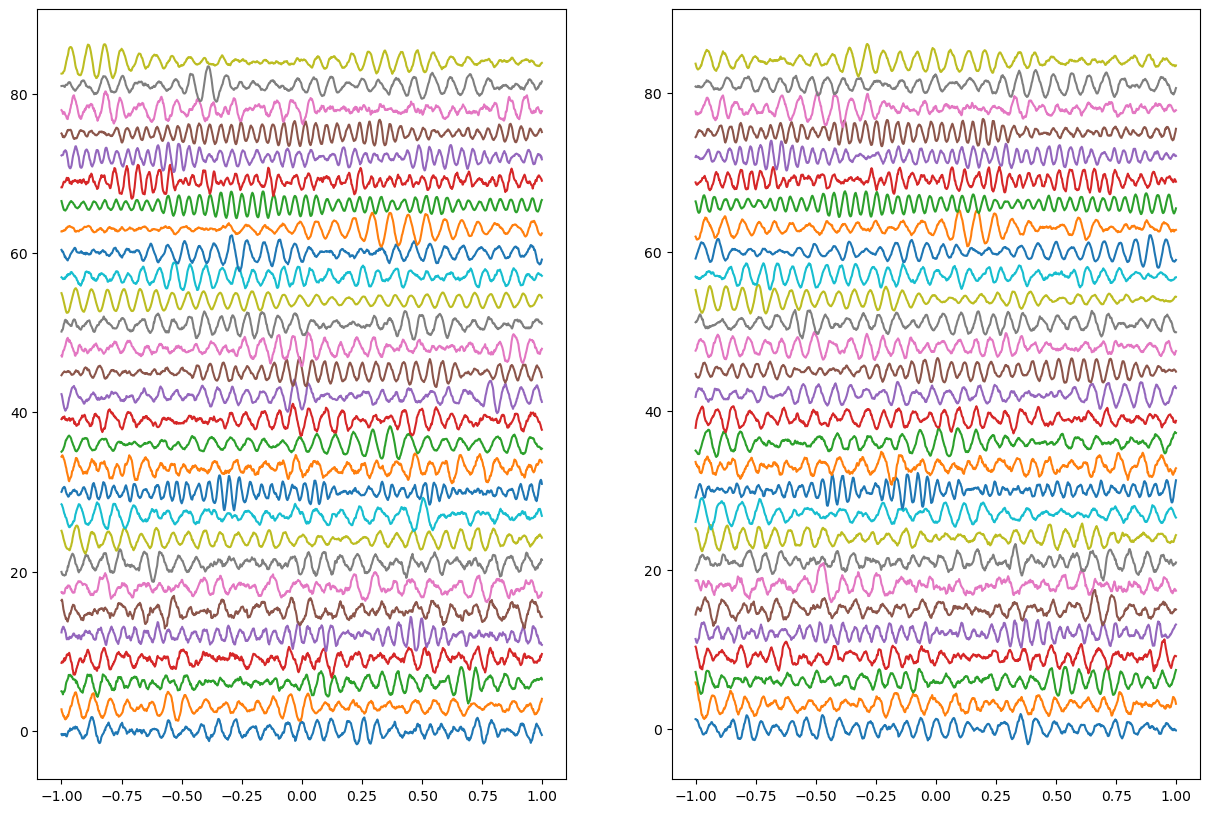

In [53]:
plt.figure(figsize=(15, 10))
z_data = (data - data.mean("times")) / data.std("times")
plt.subplot(1, 2, 1)
for i in range(Nareas):
    plt.plot(z_data[-1].times, z_data[0].values[i].real + (i * 3))
plt.subplot(1, 2, 2)
for i in range(Nareas):
    plt.plot(z_data[-1].times, z_data[-1].values[i].real + (i * 3))

In [54]:
Sxx, fc = psd_array_multitaper(data.real, fsamp // decim, 0, 40, bandwidth=2)

    Using multitaper spectrum estimation with 3 DPSS windows


In [55]:
Sxx = xr.DataArray(
    Sxx,
    dims=("trials", "roi", "freqs"),
    coords={"trials": data.trials.values, "roi": data.roi.values, "freqs": fc},
)

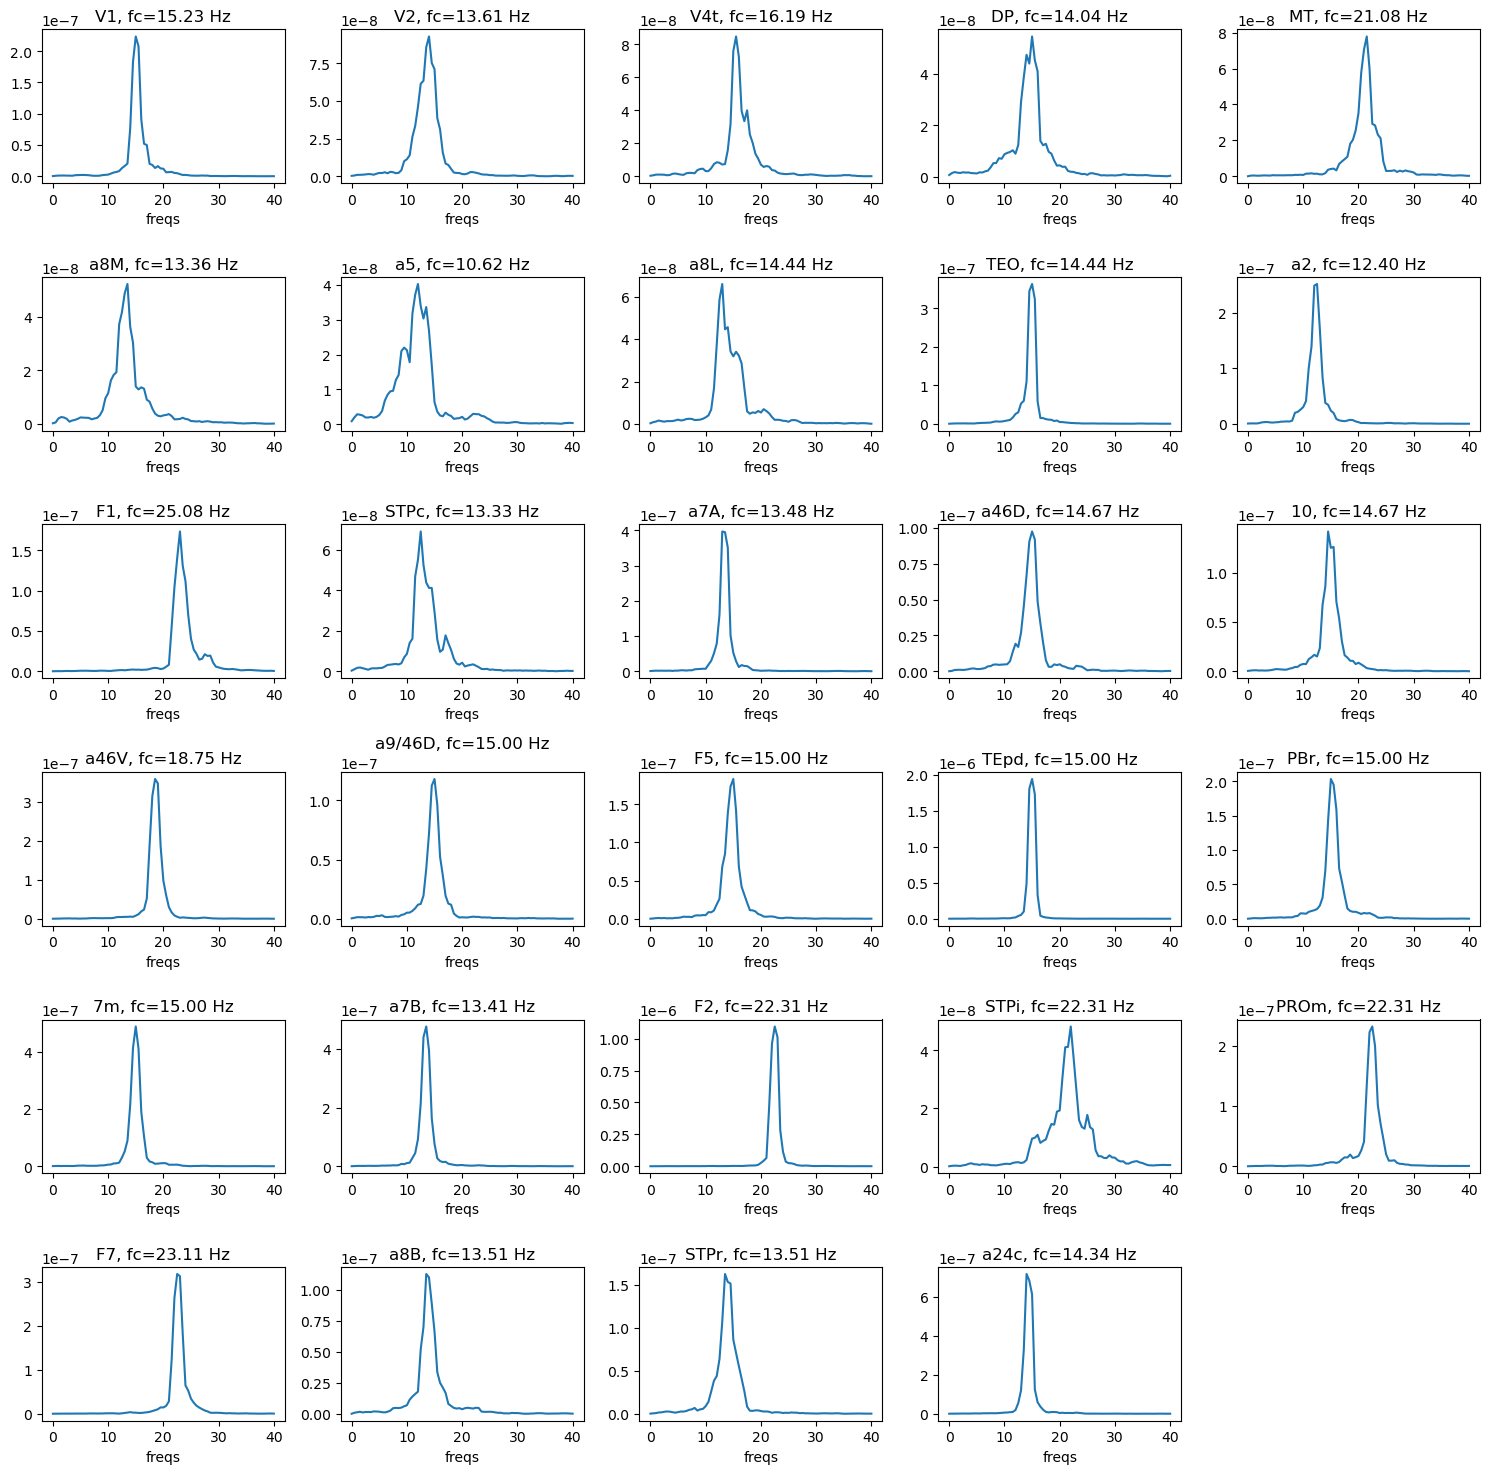

In [56]:
plt.figure(figsize=(15, 15))
for pos, i in enumerate(range(Nareas)):
    plt.subplot(6, 5, pos + 1)
    Sxx.isel(roi=i).mean("trials").plot()
    plt.title(f"{area_names[i]}, fc={f_model.values[i]:.2f} Hz")
plt.tight_layout()

<BarContainer object of 29 artists>

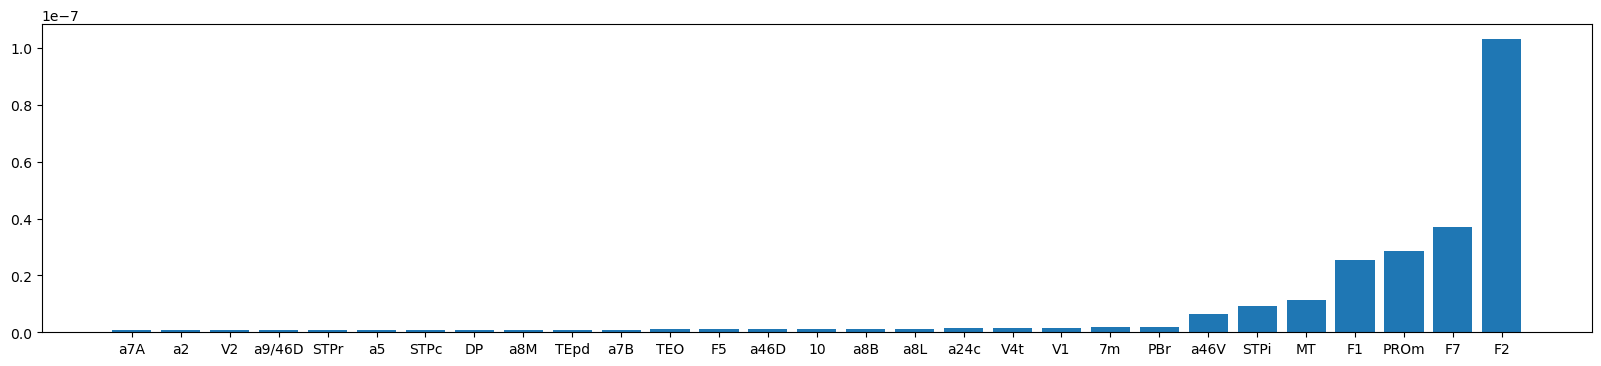

In [80]:
plt.figure(figsize=(20, 4))

x = Sxx.sel(freqs=slice(20, 40)).mean(("trials", "freqs")).data
indexes = np.argsort(x)
plt.bar( Sxx.roi.values[indexes],  np.sort(x))

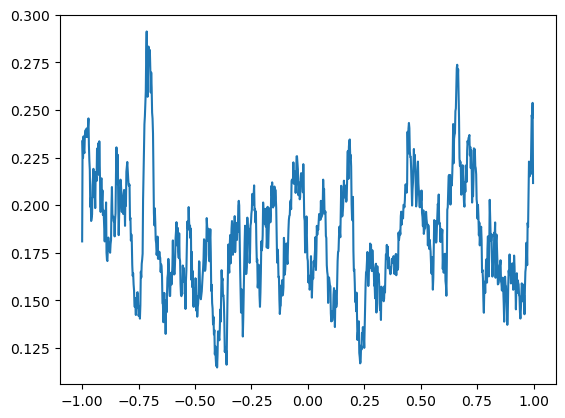

In [37]:
import scipy

theta = np.angle(scipy.signal.hilbert(data.real, axis=2))

plt.plot(data.times, np.abs(np.exp(1j * theta).mean(axis=1)).mean(0))

#### Decompose in time-frequency domain


In [38]:
freqs = np.linspace(0.3, 80, 30)

S = tfr_array_morlet(
    data.values.real,
    fsamp / decim,
    freqs,
    freqs / 7,
    output="complex",
    n_jobs=1,
    zero_mean=False,
    verbose=True,
)

S = xr.DataArray(
    S,
    dims=("trials", "roi", "freqs", "times"),
    coords={"freqs": freqs, "times": data.times.values, "roi": area_names},
)

100%|████████████████████████████████████████████████████████| 28/28 [00:17<00:00,  1.63it/s]


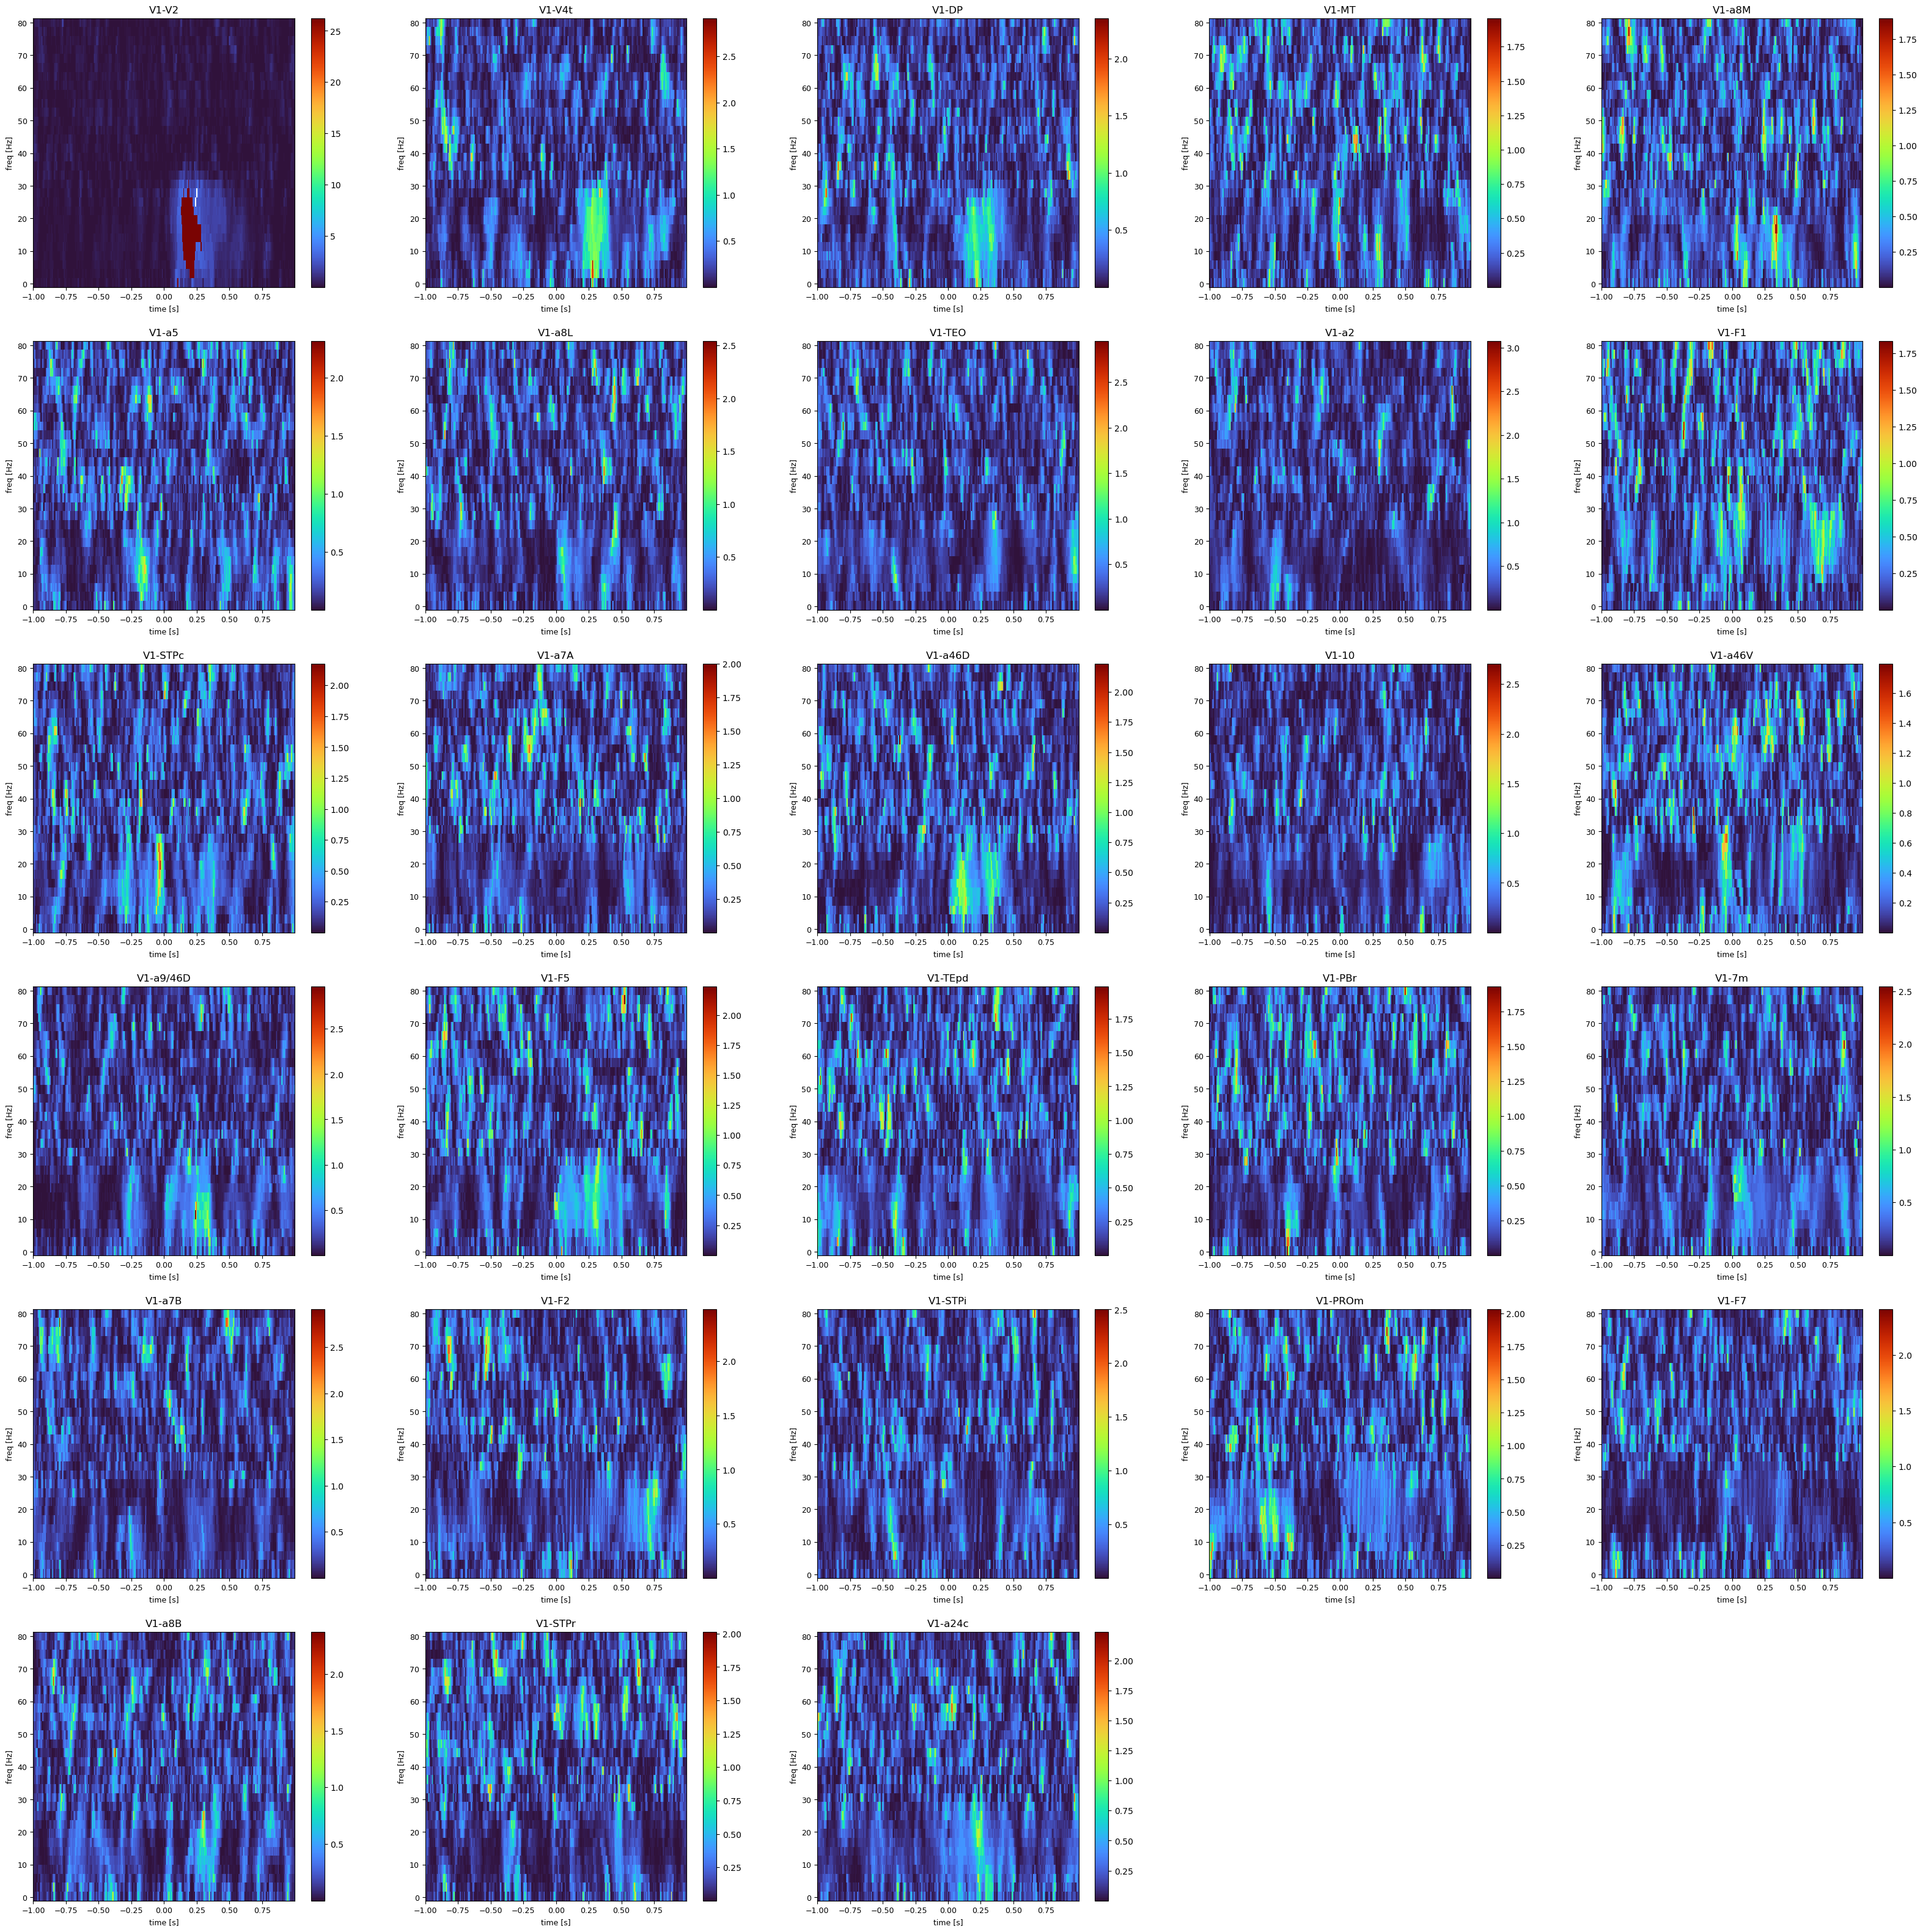

In [39]:
### Compute phase and amplitude terms


def _mi(S, roi_x, roi_y, stim):

    # Define the function to compute MI using HOI and JAX
    mi_fcn = get_mi("gc")

    # vectorize the function to first and second dimension
    gcmi = jax.vmap(jax.vmap(mi_fcn, in_axes=0), in_axes=0)

    times, freqs = S.times.values, S.freqs.values
    x = S.sel(roi=[roi_x]).data.squeeze()
    y = S.sel(roi=[roi_y]).data.squeeze()

    edge = x * np.conj(y)
    edge_r, edge_i = np.real(edge), np.imag(edge)

    E1 = np.stack((edge_r, edge_i), axis=1)
    E1 = np.moveaxis(E1, [0, 1], [-1, -2])

    # Stims across trials
    stim = data.trials.values
    stim = np.expand_dims(stim, axis=(0, 1))
    stim = np.tile(stim, (len(freqs), data.sizes["times"], 1, 1))

    E1 = copnorm_nd(E1, axis=-1)
    stim = copnorm_nd(stim, axis=-1)

    mi = gcmi(E1, stim).T

    return xr.DataArray(mi, dims=("times", "freqs"), coords=(times, freqs))


pairs = np.stack([[[0] * 28], [range(1, 29)]], axis=1).squeeze().T

rois = S.roi.values
stim = np.arange(100)  # data.trials.values

out = []
for i, j in tqdm(pairs):
    out += [_mi(S, rois[i], rois[j], stim)]


plt.figure(figsize=(40, 40))

for pos, _out in enumerate(out):
    plt.subplot(6, 5, pos + 1)
    i, j = pairs[pos]
    _out.T.plot(
        cmap="turbo",
    )
    plt.title(f"{rois[i]}-{rois[j]}")
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    plt.ylabel("freq [Hz]", fontsize=9)
    plt.xlabel("time [s]", fontsize=9)

In [40]:
x = data.sel(roi="V1") * np.conj(data.sel(roi="a24c"))

R1 = (x * np.conj(x)).data.real
R2 = np.unwrap(np.angle(x))

In [41]:
# Stims across trials
stim = np.expand_dims(Amplitudes, axis=(0, 1))
stim = np.tile(stim, (data.sizes["times"], 1)).squeeze().T

Text(0.5, 0, 'time [s]')

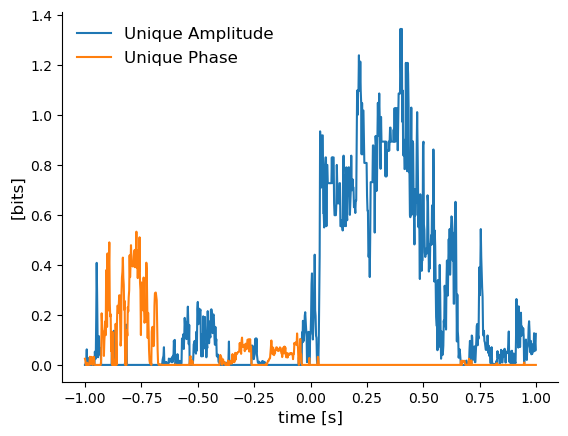

In [42]:
from frites.core import copnorm_nd, gccmi_nd_ccc, gcmi_1d_cc, gcmi_nd_cc

ax = plt.subplot(111)
I_S_12 = gccmi_nd_ccc(R1, R2, stim, traxis=0)
I_S_1 = gcmi_nd_cc(stim, R1, traxis=0)
I_S_2 = gcmi_nd_cc(stim, R2, traxis=0)
R_12 = np.minimum(I_S_1, I_S_2)

# plt.plot(S.times.values, I_S_12)
plt.plot(x.times.values, I_S_1 - R_12)
plt.plot(x.times.values, I_S_2 - R_12)
plt.legend(
    ["Unique Amplitude", "Unique Phase"],
    fontsize=12,
    frameon=False,
)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.ylabel("[bits]", fontsize=12)
plt.xlabel("time [s]", fontsize=12)